In [258]:
# Audio preprocessing
import librosa
import soundfile as sf
import numpy as np
from pydub import AudioSegment
import seaborn as sns

In [259]:
def load_audio(file_path, target_sr=16000):
    """
    Load a WAV audio file and resample it to a fixed sampling rate.
    
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sampling rate (default: 16kHz).
    
    Returns:
        y (numpy array): Audio waveform.
        sr (int): Sampling rate of the loaded audio.
    """
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

In [260]:
def rms_normalization(audio, target_rms=0.1):
    """
    Normalize the audio signal to a fixed RMS (Root Mean Square) value.

    Args:
        audio (numpy array): Input audio waveform.
        target_rms (float): Target RMS level.

    Returns:
        y_norm (numpy array): RMS-normalized audio waveform.
    """
    rms = np.sqrt(np.mean(audio**2))  # Compute current RMS
    scaling_factor = target_rms / (rms + 1e-10)  # Avoid division by zero
    y_norm = audio * scaling_factor  # Scale audio to match target RMS

    return y_norm

In [261]:
def calculate_features(audio_path):
    y, sr = load_audio(audio_path)  # Load and resample
    y_norm = rms_normalization(y)  # Normalize volume
    features = {}
    # --- 1. MFCCs ---
    mfccs = librosa.feature.mfcc(y=y_norm, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    features['mfccs'] = mfccs_mean
    
    # --- 2. Spectral Entropy ---
    spec = np.abs(librosa.stft(y_norm, n_fft=2048))
    col_sums = np.sum(spec, axis=0, keepdims=True)

    # Prevent division by zero
    col_sums[col_sums == 0] = 1e-10
    prob_dist = spec / col_sums

    entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10), axis=0)
    features['spectral_entropy'] = np.mean(entropy)

    
    # --- 3. Zero-Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y_norm)
    features['zcr'] = np.mean(zcr)
    
    # --- 4. Spectral Centroid ---
    centroid = librosa.feature.spectral_centroid(y=y_norm, sr=sr)
    features['spectral_centroid'] = np.mean(centroid)
    
    # ✅ 5. Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_norm, sr=sr)
    bandwidth_mean = np.mean(spectral_bandwidth)
    features['spectral_bandwith'] = bandwidth_mean
    
     # Combine into a single feature vector
    feature_vector = np.concatenate([
        features['mfccs'],
        [features['spectral_entropy']],
        [features['zcr']],
        [features['spectral_centroid']],
        [features['spectral_bandwith']]
    ])
    return feature_vector

In [262]:
audios = [
    'output_audios/audio1.wav',
    'output_audios/audio2.wav',
    'output_audios/audio3.wav',
    'output_audios/audio5.wav',
    'output_audios/audio6.wav',
    'output_audios/audio7.wav',
    'output_audios/audio8.wav',
    'output_audios/audio9.wav',
    'output_audios/audio10.wav',
    'output_audios/audio11.wav',
    'output_audios/audio12.wav',
    'output_audios/audio13.wav',
    'output_audios/audio14.wav',
    'output_audios/audio15.wav',
    'output_audios/audio16.wav',
    'output_audios/audio17.wav',
    
]
X = [calculate_features(audio) for audio in audios]

In [263]:
X

[array([-1.15282898e+02,  1.33760696e+02, -2.47462921e+01,  4.56455803e+01,
        -2.85112019e+01,  1.40439081e+01, -1.89290295e+01,  2.23694038e+01,
        -1.23675194e+01,  7.94238997e+00, -1.11199665e+01,  5.90307570e+00,
        -3.29176235e+00,  8.24116039e+00,  1.03917321e-01,  1.32087362e+03,
         1.37870095e+03]),
 array([-1.42581100e+02,  1.51977066e+02, -7.94221725e+01,  3.86721725e+01,
        -3.52597351e+01, -1.77924156e+01, -9.13916969e+00, -2.54057903e+01,
        -5.53045416e+00, -1.61189728e+01, -7.76212549e+00, -1.53763056e+01,
        -1.14548378e+01,  8.15157223e+00,  1.07477232e-01,  1.30460807e+03,
         1.08008023e+03]),
 array([-9.32346649e+01,  6.71615219e+01, -4.60623970e+01,  9.22339916e+00,
        -8.21910095e+00, -1.41167796e+00,  4.60120678e+00, -6.97902441e-01,
        -1.12732925e+01,  4.84043550e+00, -8.19958591e+00, -3.59120011e+00,
        -1.75857043e+00,  8.57074928e+00,  2.09018441e-01,  2.05595671e+03,
         1.59471832e+03]),
 array(

In [264]:
# Step 4 - Clustering
from sklearn.preprocessing import StandardScaler
import hdbscan

In [265]:
# --- Step 1: Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.26275423,  0.5670341 , -0.96340952,  2.5859001 , -2.06965407,
         1.92799886, -1.59726451,  2.29716781, -1.44449946,  1.33659017,
        -0.82100371,  1.42625976,  1.53469052,  0.27138949,  0.45531921,
         0.12854142, -0.30542851],
       [ 0.15206748,  1.08771143, -2.94366846,  2.06525616, -2.83424244,
        -1.90291696,  0.15944719, -1.98382926,  0.71283841, -2.09411884,
         0.46295472, -2.55695097, -0.5916518 ,  0.22667429,  0.53302943,
         0.09079585, -0.996572  ],
       [ 0.35215379, -1.33656585, -1.73543929, -0.1334286 ,  0.22937946,
         0.06820344,  2.62504738,  0.23017316, -1.09923188,  0.89430835,
         0.29568027, -0.35093953,  1.93406094,  0.43589376,  2.74959864,
         1.8343634 ,  0.19453345],
       [-3.85720528, -3.25623934, -0.06714474, -0.8220599 ,  1.16057869,
         0.23807291,  1.79939779,  0.29271018,  2.45789391,  0.20415103,
         3.43100664,  0.32128428,  2.39213863, -3.84193498, -1.81311878,
        -2.93665662

In [266]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
X_2d = pca.fit_transform(X_scaled)
# print(X_2d)

# # Visualize: color first 11 as one group
# colors = ['blue']*4 + ['red']*11

# plt.figure(figsize=(6,4))
# plt.scatter(X_2d[:,0], X_2d[:,1], c=colors)
# plt.title("PCA Projection - First 11 are 'same environment'")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.grid(True)
# plt.show()

In [281]:
# --- Step 2: Cluster using HDBSCAN ---
from sklearn.decomposition import PCA
# Reduce dimensions first

# Now cluster on the PCA-reduced data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1,prediction_data=True)
labels = clusterer.fit_predict(X_2d)
labels

/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([ 0, -1,  0, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [268]:
# plt.figure(figsize=(6, 4))
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=60)
# plt.title("HDBSCAN Clustering on PCA Projection")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.grid(True)
# plt.show()

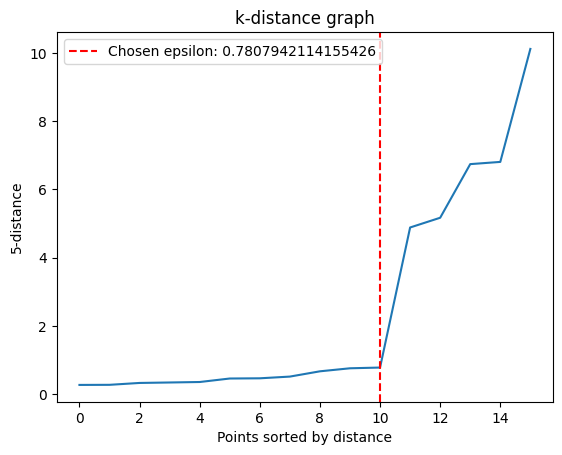

Chosen epsilon value: 0.7807942114155426


In [269]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

# Step 1: Calculate k-distances
k = 5  # min_samples value
nbrs = NearestNeighbors(n_neighbors=k).fit(X_2d)
distances, indices = nbrs.kneighbors(X_2d)

# Sort the distances in ascending order
distances = np.sort(distances[:, -1], axis=0)

# Step 2: Use KneeLocator to find the optimal epsilon (elbow)
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
epsilon = distances[kneedle.elbow]


# Step 3: Plot the k-distance graph and highlight the chosen epsilon
plt.plot(distances)
plt.axvline(x=kneedle.elbow, color='r', linestyle='--', label=f'Chosen epsilon: {epsilon}')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-distance')
plt.title('k-distance graph')
plt.legend()
plt.show()

# Step 4: Use the optimal epsilon for DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=k)
labels = dbscan.fit_predict(X_2d)

print(f"Chosen epsilon value: {epsilon}")

In [ ]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=epsilon, min_samples=5)
labels = clusterer.fit_predict(X_2d)
labels

array([-1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])